# cuda:4

In [29]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema, argrelmax
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec



import traceback
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_num_threads(4)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value std id {STD:.3f}')
print(f'Train {TRAINLENGTH} Test {TEST} M {M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000
Normalizing value max-min id 38.053
Normalizing value std id 7.912
Train 14000 Test 1000 M 15000


In [30]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [31]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [32]:
'''
fpath = 'Dicts/X/diag_Lx_lg1000.json'
with open(fpath,'r') as j:
    dict_diag1 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx_lg1000.json'
with open(fpath,'r') as j:
    dict_models1 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx.json'
with open(fpath,'r') as j:
    dict_diag2 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx.json'
with open(fpath,'r') as j:
    dict_models2 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx300.json'
with open(fpath,'r') as j:
    dict_diag3 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx300.json'
with open(fpath,'r') as j:
    dict_models3 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx_lg.json'
with open(fpath,'r') as j:
    dict_diag4 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx_lg.json'
with open(fpath,'r') as j:
    dict_models4 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx_sm1.json'
with open(fpath,'r') as j:
    dict_diag5 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx_sm1.json'
with open(fpath,'r') as j:
    dict_models5 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx_sm2.json'
with open(fpath,'r') as j:
    dict_diag6 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx_sm2.json'
with open(fpath,'r') as j:
    dict_models6 = json.loads(j.read())

fpath = 'Dicts/X/diag_Lx_sm3.json'
with open(fpath,'r') as j:
    dict_diag7 = json.loads(j.read())

fpath = 'Dicts/X/models_Lx_sm3.json'
with open(fpath,'r') as j:
    dict_models7 = json.loads(j.read())

dict_diag = { **dict_diag1,**dict_diag2,**dict_diag3,**dict_diag4,**dict_diag5,**dict_diag6,**dict_diag7}
dict_models = { **dict_models1,**dict_models2,**dict_models3,**dict_models4,
               **dict_models5,**dict_models6,**dict_models7}
'''

"\nfpath = 'Dicts/X/diag_Lx_lg1000.json'\nwith open(fpath,'r') as j:\n    dict_diag1 = json.loads(j.read())\n\nfpath = 'Dicts/X/models_Lx_lg1000.json'\nwith open(fpath,'r') as j:\n    dict_models1 = json.loads(j.read())\n\nfpath = 'Dicts/X/diag_Lx.json'\nwith open(fpath,'r') as j:\n    dict_diag2 = json.loads(j.read())\n\nfpath = 'Dicts/X/models_Lx.json'\nwith open(fpath,'r') as j:\n    dict_models2 = json.loads(j.read())\n\nfpath = 'Dicts/X/diag_Lx300.json'\nwith open(fpath,'r') as j:\n    dict_diag3 = json.loads(j.read())\n\nfpath = 'Dicts/X/models_Lx300.json'\nwith open(fpath,'r') as j:\n    dict_models3 = json.loads(j.read())\n\nfpath = 'Dicts/X/diag_Lx_lg.json'\nwith open(fpath,'r') as j:\n    dict_diag4 = json.loads(j.read())\n\nfpath = 'Dicts/X/models_Lx_lg.json'\nwith open(fpath,'r') as j:\n    dict_models4 = json.loads(j.read())\n\nfpath = 'Dicts/X/diag_Lx_sm1.json'\nwith open(fpath,'r') as j:\n    dict_diag5 = json.loads(j.read())\n\nfpath = 'Dicts/X/models_Lx_sm1.json'\nwith

In [33]:
#with open('Dicts/diagX.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsX.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

fpath = 'Dicts/diagX.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/modelsX.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [34]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### The predictions below are purely from the refinement process in the paper.  There is no handpicking of models.

In [35]:
size = [1000,800,600,400,300,200,100,50,40,30,28,26,24,22,20,18,16,14,12,10]

In [36]:
mean_errors = []
num_models = []


    
for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
#np.save('num_modelsX',num_models)

In [37]:
num_models

[92,
 45,
 47,
 25,
 87,
 21,
 12,
 117,
 100,
 105,
 16,
 27,
 32,
 25,
 107,
 108,
 113,
 107,
 104,
 102]

[102 104 107 113 108 107  25  32  27  16 105 100 117  12  21  87  25  47
  45  92]
[126   4   0   5   4   2   1   4   2   1 128 125 110  65  52  79  62  55
  75  70]
[ 98   0   0   0   0  98   0   0   1   4  90  90  89   2   5 108   6   7
   7   5]
[116   0   0   0   1   1   0   2   3   6 110 118 117  20  33 119  49  61
  64  65]


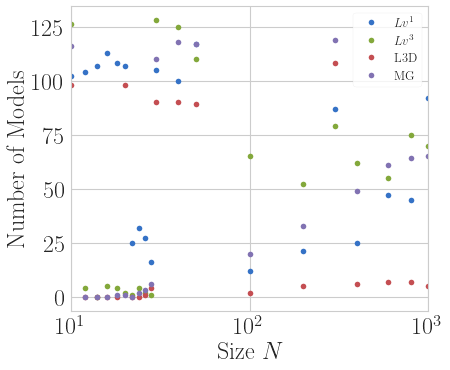

In [38]:
mname = ['num_modelsX.npy', 'num_modelsZ.npy', 'num_modelsL3D.npy', 'num_modelsMG.npy']
labels = ['$Lv^{1}$','$Lv^{3}$','L3D','MG']
for i in range(len(mname)):
    num_models = np.load(mname[i])
    print(num_models[::-1])
    plt.semilogx(size[::-1],num_models[::-1],'o',label=labels[i])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.legend(loc='upper right')
plt.show()

N=1000   Error = 0.125 KL-div = 0.181 E*kl=0.023
N=800   Error = 0.16 KL-div = 0.154 E*kl=0.025
N=600   Error = 0.17 KL-div = 0.619 E*kl=0.105
N=400   Error = 0.164 KL-div = 0.148 E*kl=0.024
N=300   Error = 0.188 KL-div = 0.396 E*kl=0.075
N=200   Error = 0.167 KL-div = 0.402 E*kl=0.067
N=100   Error = 0.208 KL-div = 0.206 E*kl=0.043
N=50   Error = 0.203 KL-div = 0.397 E*kl=0.080
N=40   Error = 0.214 KL-div = 0.501 E*kl=0.107
N=30   Error = 0.208 KL-div = 3.582 E*kl=0.745
N=28   Error = 0.217 KL-div = 0.263 E*kl=0.057
N=26   Error = 0.223 KL-div = 1.041 E*kl=0.232
N=24   Error = 0.213 KL-div = 1.213 E*kl=0.258
N=22   Error = 0.217 KL-div = 0.556 E*kl=0.121
N=20   Error = 0.208 KL-div = 0.795 E*kl=0.166
N=18   Error = 0.224 KL-div = 0.468 E*kl=0.105
N=16   Error = 0.222 KL-div = 0.881 E*kl=0.195
N=14   Error = 0.22 KL-div = 0.621 E*kl=0.136
N=12   Error = 0.224 KL-div = 0.373 E*kl=0.084
N=10   Error = 0.222 KL-div = 0.627 E*kl=0.139


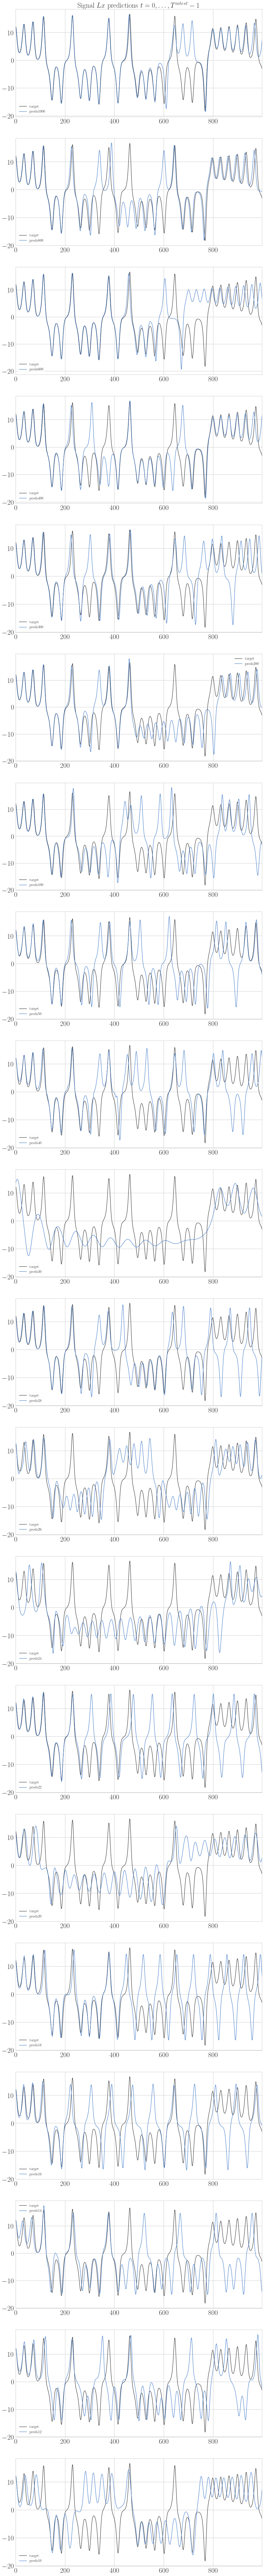

In [39]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {error_testset.round(3)} KL-div = {kl:.3f} E*kl={Ekl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### For N=50,28,12 the product of Error*KLdiv ~= .08

### Get indicated rank to reduce to

Targeted reduced rank for N=1000 is 36
Value v= 9 Tolerance 1e-14 Rho A 1.248
Alpha 0.8823628230711406 --- Gamma 1.0

Targeted reduced rank for N=800 is 42
Value v= 10 Tolerance 1e-15 Rho A 1.213
Alpha 0.8595279072332106 --- Gamma 1.0

Targeted reduced rank for N=600 is 33
Value v= 10 Tolerance 1e-15 Rho A 1.18
Alpha 0.7468022444863948 --- Gamma 1.0

Targeted reduced rank for N=400 is 30
Value v= 10 Tolerance 1e-15 Rho A 1.234
Alpha 0.7278175175658347 --- Gamma 1.0

Targeted reduced rank for N=300 is 32
Value v= 10 Tolerance 1e-15 Rho A 1.254
Alpha 0.7586015704838707 --- Gamma 1.0

Targeted reduced rank for N=200 is 39
Value v= 9 Tolerance 1e-14 Rho A 1.203
Alpha 0.811857777803251 --- Gamma 1.0

Targeted reduced rank for N=100 is 56
Value v= 11 Tolerance 1e-16 Rho A 1.193
Alpha 0.5023998716183413 --- Gamma 1.0

Targeted reduced rank for N=50 is 43
Value v= 11 Tolerance 1e-16 Rho A 0.987
Alpha 0.5091509864618499 --- Gamma 1.0

Targeted reduced rank for N=40 is 35
Value v= 10 Tolerance 1

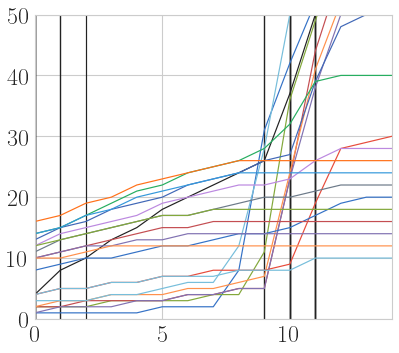

In [40]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)
all_ranks = []
K = 1
L = 1
tols = [1/10**x for x in range(5,20)]
np.zeros(len(size),)
plt.figure()
for n in size:
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
    print(f'Alpha {a} --- Gamma {g}\n')
    all_ranks.append(ave_rank)
plt.ylim(0,50)
plt.show()

In [41]:
rMG = np.load('ranksMG.npy')
rL3D = np.load('ranksL3D.npy')
rZ = np.load('ranksZ.npy')

mean_errorL3D  = np.load('mean_errorL3D.npy')
mean_errorMG  = np.load('mean_errorMG.npy')
mean_errorLz  = np.load('mean_errorLz.npy')

In [42]:
dict_diag['100'].keys()

dict_keys(['numModels', 'meanError', 'varError'])

In [43]:
mean_error = []
for i in size:
    err = dict_diag[str(i)]['meanError']
    mean_error.append(err)
    print(f'N={i}   number {err}')
    

N=1000   number 0.22625776006444986
N=800   number 0.2072652382580714
N=600   number 0.21217292631619253
N=400   number 0.20669813493982506
N=300   number 0.24342867021211925
N=200   number 0.20868450828583357
N=100   number 0.217826595552401
N=50   number 0.26456963019905316
N=40   number 0.2629310588507301
N=30   number 0.2635436542289929
N=28   number 0.2151543999597687
N=26   number 0.2149039555267999
N=24   number 0.21400176503553311
N=22   number 0.21504035461648005
N=20   number 0.2661345498332799
N=18   number 0.2650759999986289
N=16   number 0.266496426550544
N=14   number 0.2622993660599652
N=12   number 0.2569752763216356
N=10   number 0.26156781401519674


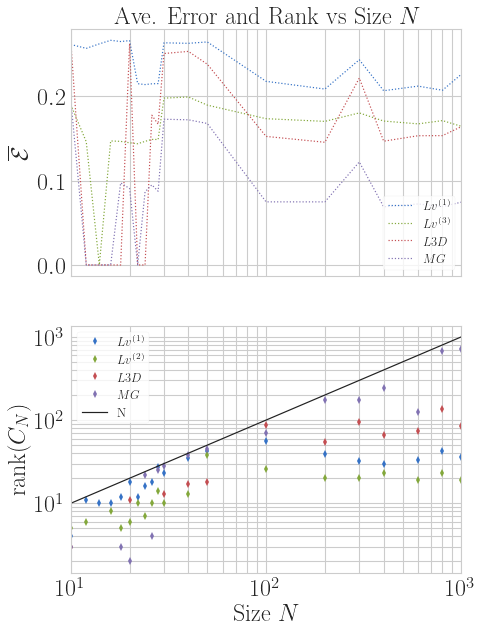

In [44]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True, figsize=(7,10))
ax[0].set_title('Ave. Error and Rank vs Size $N$ ')
ax[0].semilogx(size[::-1],mean_error[::-1],linestyle='dotted', label='$Lv^{(1)}$')
ax[0].semilogx(size[::-1],mean_errorLz[::-1],linestyle='dotted', label='$Lv^{(3)}$')
ax[0].semilogx(size[::-1],mean_errorL3D[::-1],linestyle='dotted', label='$L3D$')
ax[0].semilogx(size[::-1],mean_errorMG[::-1],linestyle='dotted', label='$MG$')
#ax[0].set_xlabel('Size $N$')
ax[0].set_ylabel('$\overline{\mathcal{E}}$')
ax[0].grid(True, which="both", ls="-")
ax[0].legend(loc='lower right')

ax[1].loglog(size[::-1],all_ranks[::-1],'d', label='$Lv^{(1)}$')
ax[1].loglog(size[::-1],rZ[::-1],'d', label='$Lv^{(2)}$')
ax[1].loglog(size[::-1],rL3D[::-1],'d', label='$L3D$')
ax[1].loglog(size[::-1],rMG[::-1],'d', label='$MG$')
ax[1].loglog(size[::-1],size[::-1],color='k', label='N')
ax[1].set_xlabel('Size $N$')
ax[1].set_ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
ax[1].legend()
plt.show()
fig.savefig("../PlotNBs/NBoutputs/mm_rank_and_error.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$

In [45]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


k=N=1000 Trainingset min=0.817  threshold=0.777  Location=13
k=N=800 Trainingset min=0.662  threshold=0.629  Location=210
k=N=600 Trainingset min=0.954  threshold=0.907  Location=5
k=N=400 Trainingset min=0.627  threshold=0.596  Location=240
k=N=300 Trainingset min=0.872  threshold=0.828  Location=2
k=N=200 Trainingset min=0.993  threshold=0.943  Location=127
k=N=100 Trainingset min=0.991  threshold=0.941  Location=149
k=N=50 Trainingset min=0.99  threshold=0.940  Location=175
k=N=40 Trainingset min=0.984  threshold=0.935  Location=78
k=N=30 Trainingset min=0.859  threshold=0.816  Location=1
k=N=28 Trainingset min=0.975  threshold=0.926  Location=265
k=N=26 Trainingset min=0.967  threshold=0.919  Location=17
k=N=24 Trainingset min=0.921  threshold=0.875  Location=1
k=N=22 Trainingset min=0.971  threshold=0.923  Location=80
k=N=20 Trainingset min=0.896  threshold=0.851  Location=41
k=N=18 Trainingset min=0.964  threshold=0.916  Location=81
k=N=16 Trainingset min=0.959  threshold=0.911  

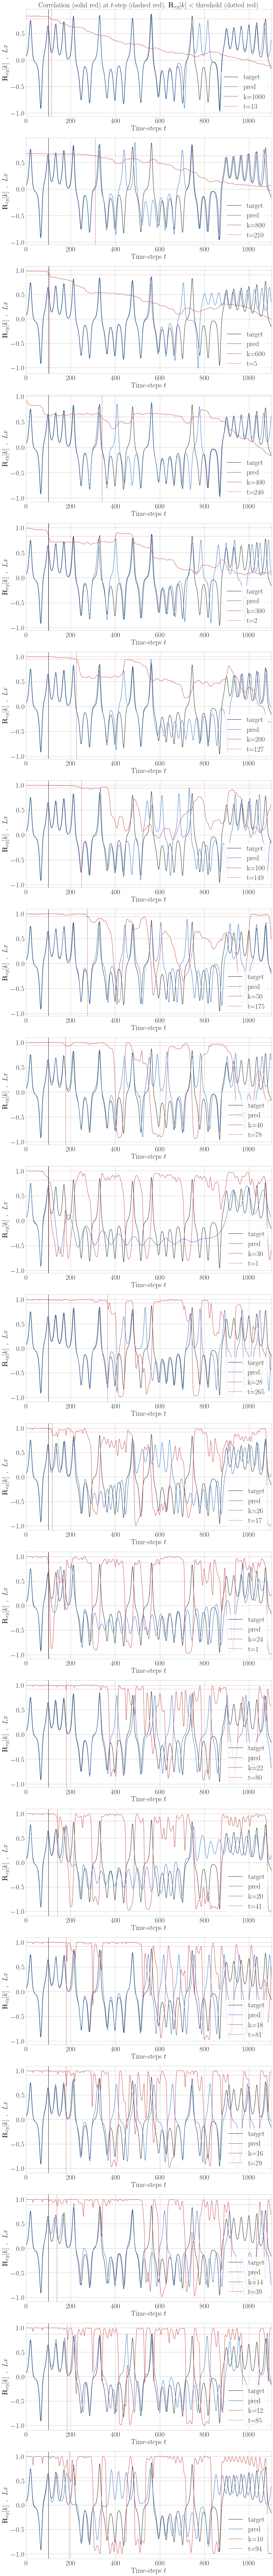

In [46]:
LEAD = 100
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos plot

In [47]:
from scipy.signal import argrelmax
import pandas as pd
import seaborn as sns

In [48]:
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    radii = np.zeros(T)
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, wi, wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, wi, wr)
        Cplus = rca.gpu_reachable_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
    return ranks, radii

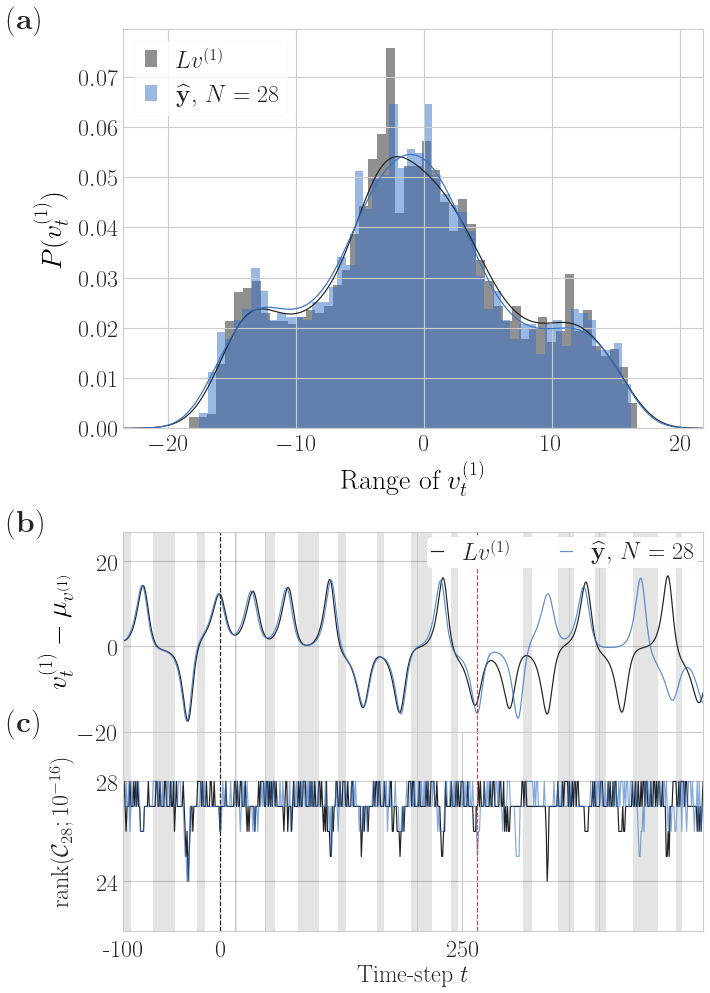

In [49]:
N = 28
K = 1
v = 5
pred = np.array(dict_models[str(N)]['Preds'])
start, end= 13900,15000
p = dict_models[str(N)]['Params']
mat = np.array(dict_models[str(N)]['Wnet'])
Wr, Wi = rca.get_mats(None, K,N, matrix=mat)
sig_rks, radii = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end], N, K, tols[v])
pred_rks,_ = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            pred[start:end],N, K, tols[v])

top,bottom  = 13900,15000
mu = .56018255




gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28


data_dict = {'y': signal[14000:],
             'yh30': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(1)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh30'],
             label='$\widehat{\mathbf{y}},\,N=28$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper left', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(1)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(1)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,14500
xax = np.array([k for k in range(start,end)],dtype=int)
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=0)

ax2 = plt.subplot(gs1[0])
ax2.plot(xax,signal[start:end],'k', label=r'$Lv^{(1)}$')
ax2.plot(xax,pred[start:end],'b-', label='$\widehat{\mathbf{y}},\,N=28$', alpha = .8)
ax2.set_ylim(-20,27)
ax2.legend(loc='upper right',
           framealpha=1,
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)

ax2.set_ylabel(r'$v^{(1)}_t-\mu_{v^{(1)}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])


ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.plot(xax,sig_rks[:-500],
        color='k', label='$Lv^{(1)}$', alpha=1.)
ax3.plot(xax,pred_rks[:-500],
        color= 'b', label='$\widehat{\mathbf{y}}$', alpha=.6)
lowlim, uplim = 22,30
ax3.set_ylim(lowlim, uplim)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{28};10^{-16})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
ax3.set_xticks([13900,14000,14250,14500])
ax3.set_xticklabels([-100,0,250,500])
ax3.set_yticks([24,28])
ax3.set_yticklabels([24,28])

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14265, c='r',ls='dashed' )
ax2.vlines(np.where(radii[:-500]>1.13)[0] + 13900, -25,27, color='k', linewidths=1, alpha=.12)
ax3.vlines(np.where(radii[:-500]>1.13)[0] + 13900, lowlim,uplim, color='k', linewidths=1, alpha=.12)
ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14265, c='r',ls='dashed' )
plt.tight_layout()
plt.show()
#fig.savefig("../PlotNBs/NBoutputs/Lx_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

### Sensitivity

In [ ]:
signal = np.load('../Targets/Xsignal.npy')

BURNIN = 100
VSET = 100
FREERUN = 1000
T = signal.shape[0]
M = T-FREERUN
TEST = 1000
TRAINLENGTH = M-TEST

DEVICE = 'cuda:2'
DTYPE = torch.float32
S = torch.from_numpy(signal).cuda(DEVICE).type(DTYPE)

matrix = np.array(dict_models['28']['Wnet'])
original_wout = np.array(dict_models['28']['Wout'])

perturb = np.array([1 + x/1000 for x in range(-200,200,2)])

Nturbs = len(perturb)
MM = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
error_mat = np.zeros((Nturbs,Nturbs))
K,N = 1,28
L = K
p = dict_models[str(N)]['Params']
# Load in Wnet from search
# Set up GPU value holders
ut = torch.zeros((1,1),dtype=DTYPE,
                     device=torch.device(DEVICE))
tp = torch.zeros((1,1),dtype=DTYPE,
                 device=torch.device(DEVICE))
# Transfer Wnet to GPU
Wnet = torch.from_numpy(matrix).cuda(DEVICE).type(DTYPE)
# Load in best Wout to GPU
Wout = torch.from_numpy(np.array(original_wout).reshape(L,N+K)).type(DTYPE).cuda(DEVICE)
for px in tqdm(range(Nturbs)):
    for py in range(Nturbs):
        a = p[0]*perturb[px]
        g = p[2]*perturb[py]
        # Holder for predictions
        predictions = torch.zeros((M+FREERUN,1),
                                  dtype=DTYPE,
                                  device=torch.device(DEVICE))
        # Initial vectors... Start prediction from beginning
        xt, yt = set_vectorsGPU(N,L,p[4])
        for i in range(M+FREERUN):
            if(i < TRAINLENGTH):
                ut[0,0] = S[i]
            else:
                ut = yt
            uxy = torch.cat((ut,xt,yt),0)
            xt1 = update_res_stateGPU(Wnet,xt,uxy,a,g)
            xu = torch.cat((xt1,ut),0)
            yt1 = predict_yGPU(Wout,xu)
            predictions[i] = yt1[0,0]
            xt, yt = xt1, yt1

        yHat = predictions.detach().cpu().numpy()
        try:
            nrmse_t = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                                yHat[TRAINLENGTH:TRAINLENGTH+TEST],
                                MM)
        except:
            continue
        error_mat[px,py] = nrmse_t

        

In [ ]:
plt.imshow(error_mat)
#plt.xticks(perturb[::5].round(2), perturb[::5].round(2))
#plt.yticks(perturb[::5], perturb[::5])
plt.xlabel('% change in alpha')
plt.ylabel('% change in rho')
plt.colorbar()
plt.show()

In [ ]:
perturb = np.array([1 + x/1000 for x in range(-200,200,2)])
perturb

### Eta search

In [51]:
def Phi(wr, wi, a, g, u, n, k):
    '''Generate a sequence of state updates given a forcing sequence.
    wr = a reservoir matrix (n x n)
    wi = an input matrix (k x 1)
    a  = alpha
    g  = gamma
    u = forcing
    '''
    #pdb.set_trace()
    T = u.shape[0]
    preds = np.zeros((T,K))
    Phi = np.zeros((T,n+k))
    def Func(Wr,Wi,xt,ut,n,k):
        res = np.dot(Wr,xt)
        rdin = np.dot(Wi,ut)
        return (1-a)*xt.reshape(n,1) + a*g*np.tanh(res + rdin)
    
    xt = np.zeros(n)
    for i in range(T):
        ut = u[i]  # Get a forcing value
        xt1 = Func(wr, wi, xt.reshape(n,1), ut.reshape(k,1), n, k) # Update state
        xu = np.vstack((xt1,ut.reshape(k,1))) # combine as Phi row
        Phi[i,:] = np.squeeze(xu) # Put in Phi row i
        xt = xt1
    return Phi

def make_preds(wnet, wout, p, u, s, n, k):
    Wnet = torch.from_numpy(wnet).type(dtype).cuda(DEVICE)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    predictions = torch.zeros((k,M+int(FREERUN/deltaT)),
                              dtype=dtype,
                              device=torch.device(DEVICE))
    #print(predictions.size())
    a = p[0]
    g = p[2]
    rr = p[-2]
    s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
    xt, yt = set_vectorsGPU(N,L,rr)
    ut = torch.zeros((K,1),dtype=dtype, device=torch.device(DEVICE)) 
    for i in range(M+int(FREERUN/deltaT)):
        if(i < TRAINLENGTH):
            ut[:,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        #pdb.set_trace()
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,g)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        #print(yt1.size())
        predictions[:,i] = yt1[:,0]
        xt, yt = xt1, yt1
    return predictions.detach().cpu().numpy()

In [52]:
Wouts  = []
etaTest = [] 

N,K = 28,1
L = K
Yvar = np.max(np.var(signal[:TRAINLENGTH]))
# Wnet to split into Wr, Wi
wnet = np.array(dict_models[str(N)]['Wnet'])

Wr, Wi = rca.get_mats(None, K,N, matrix=wnet)
# params [alpha, spectralradius, gamma, ri, rr, loss]
p = dict_models[str(N)]['Params']
a,g = p[0], p[2]
# Generate states for eta search
states = Phi(Wr,Wi,a,g,signal[:TRAINLENGTH],N,K)
# Solve for Wout
testEta = [.0,1e-8,1e-7,1e-6,1e-5,
           1e-4,1e-3,1e-2,1e-1,
           1,10,100,1000]
for eta in testEta:
    currWout = rct.get_trained_weights(states[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   eta)
    Wouts.append(currWout)
    lOpt  = (N+K)*Yvar/np.linalg.norm(currWout)**2
    print(lOpt)
    etaTest.append(lOpt)

Wouts = []
all_eta = np.sort(testEta + etaTest) 
# Re-solve with optimums
# Half of Wouts should be from eta_test and second from  optimals
for eta in all_eta:
    print(eta)
    currWout = rct.get_trained_weights(states[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   eta)
    Wouts.append(currWout)

0.000779232794629127
0.0008656063865530146
0.0012621037019861384
0.003437373169833515
0.008869078454247325
0.014244632335078892
0.03894628302127322
0.11868518752605614
0.4964381889699658
2.8950187560847
19.720488367367693
198.50155800967534
821.8847617801014
0.0
1e-08
1e-07
1e-06
1e-05
0.0001
0.000779232794629127
0.0008656063865530146
0.001
0.0012621037019861384
0.003437373169833515
0.008869078454247325
0.01
0.014244632335078892
0.03894628302127322
0.1
0.11868518752605614
0.4964381889699658
1.0
2.8950187560847
10.0
19.720488367367693
100.0
198.50155800967534
821.8847617801014
1000.0


In [53]:
deltaT = .02
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
all_preds = []
for i in tqdm(range(len(Wouts))):
    yhat = make_preds(wnet, Wouts[i], p, signal, s, N, K)
    all_preds.append(yhat)

100%|███████████████████████████████████████████| 26/26 [03:10<00:00,  7.33s/it]


eta=0.0	 nrmsev=0.033	 nrmse=0.266
eta=1e-08	 nrmsev=0.029	 nrmse=0.324
eta=1e-07	 nrmsev=0.017	 nrmse=0.288
eta=1e-06	 nrmsev=0.05	 nrmse=0.45
eta=1e-05	 nrmsev=0.083	 nrmse=0.5
eta=0.0001	 nrmsev=0.134	 nrmse=0.273
eta=0.00077923	 nrmsev=0.043	 nrmse=0.281
eta=0.00086561	 nrmsev=0.041	 nrmse=0.282
eta=0.001	 nrmsev=0.042	 nrmse=0.281
eta=0.0012621	 nrmsev=0.042	 nrmse=0.278
eta=0.00343737	 nrmsev=0.06	 nrmse=0.293
eta=0.00886908	 nrmsev=0.047	 nrmse=0.265
eta=0.01	 nrmsev=0.099	 nrmse=0.294
eta=0.01424463	 nrmsev=0.114	 nrmse=0.271
eta=0.03894628	 nrmsev=0.148	 nrmse=0.293
eta=0.1	 nrmsev=0.127	 nrmse=0.324
eta=0.11868519	 nrmsev=0.132	 nrmse=0.322
eta=0.49643819	 nrmsev=0.138	 nrmse=0.286
eta=1.0	 nrmsev=0.145	 nrmse=0.27
eta=2.89501876	 nrmsev=0.161	 nrmse=0.24
eta=10.0	 nrmsev=0.192	 nrmse=0.215
eta=19.72048837	 nrmsev=0.21	 nrmse=0.212
eta=100.0	 nrmsev=0.214	 nrmse=0.208
eta=198.50155801	 nrmsev=0.19	 nrmse=0.219
eta=821.88476178	 nrmsev=0.143	 nrmse=0.22
eta=1000.0	 nrmsev=0.13

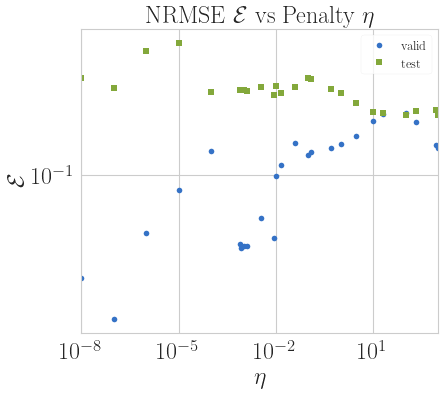

In [54]:
MM = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
errsv = []
errs = []
for i in range(len(Wouts)):
    yHat = np.array(all_preds[i])
    try:
        nrmsev = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+100],
                          yHat[0,TRAINLENGTH:TRAINLENGTH+100],
                          MM)
    except:
        nrmsev = np.nan
    
    errsv.append(nrmsev)
    
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH+100:TRAINLENGTH+TEST],
                          yHat[0,TRAINLENGTH+100:TRAINLENGTH+TEST],
                          MM)
    except:
        nrmse = np.nan
    
    errs.append(nrmse)
    
    print(f'eta={np.round(all_eta[i],8)}\t nrmsev={np.round(nrmsev,3)}\t nrmse={np.round(nrmse,3)}')
    
plt.loglog(all_eta, errsv, marker='o',
           linestyle='None', label='valid')
plt.loglog(all_eta, errs, marker='s',
           linestyle='None', label='test')
plt.legend()
plt.xlabel('$\eta$')
plt.ylabel('$\mathcal{E}$')
plt.grid(True)
plt.title('NRMSE $\mathcal{E}$ vs Penalty $\eta$')
plt.show()

In [56]:
# Error on remaining test data

preds28 = np.squeeze(np.array(dict_models['28']['Preds']))
nrmse28 = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+100],
                          preds28[TRAINLENGTH:TRAINLENGTH+100],
                          MM)


Error best 0.03    eta=0 0.026


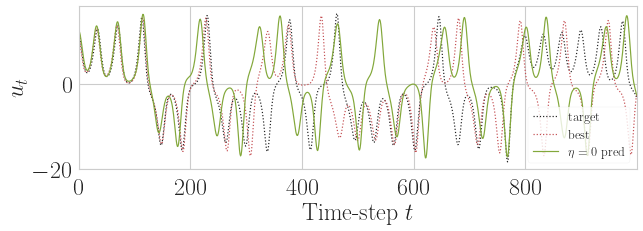

In [62]:
# Full search eta=0
fpath = 'Dicts/diag_Lx_eta0.json'
with open(fpath,'r') as j:
    eta0_diag = json.loads(j.read())

fpath = 'Dicts/models_Lx_eta0.json'
with open(fpath,'r') as j:
    eta0_models = json.loads(j.read())

predseta0 = eta0_models['28']['Preds']
eta0 = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+100],
                          predseta0[TRAINLENGTH:TRAINLENGTH+100],
                          MM)
print(f'Error best {np.round(nrmse28,3)}    eta=0 {np.round(eta0,3)}')
plt.figure(figsize=(10,3))
plt.plot(signal[TRAINLENGTH:TRAINLENGTH+TEST],ls='dotted',
         c='k', label='target')
plt.plot(preds28[TRAINLENGTH:TRAINLENGTH+TEST], ls='dotted',
         c='r', label='best')
plt.plot(predseta0[TRAINLENGTH:TRAINLENGTH+TEST],
         c='g', label=f'$\eta=0$ pred')
plt.legend(loc='lower right')
plt.xlabel('Time-step $t$')
plt.ylabel('$u_t$')
plt.legend(loc='lower right')
plt.show()

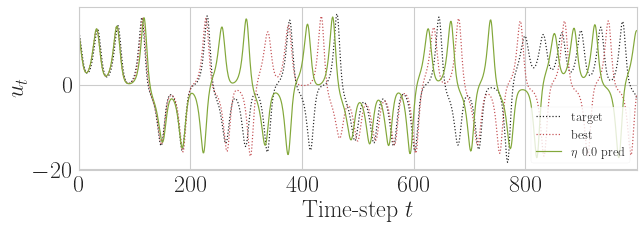

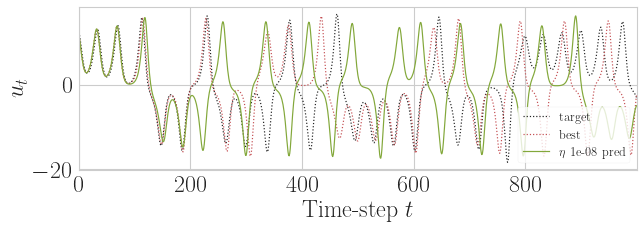

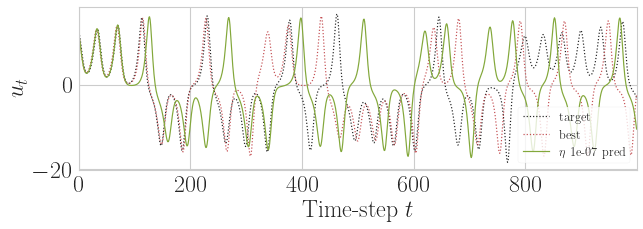

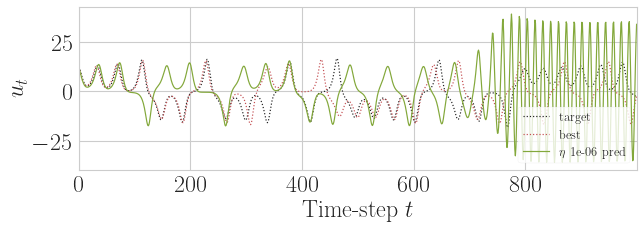

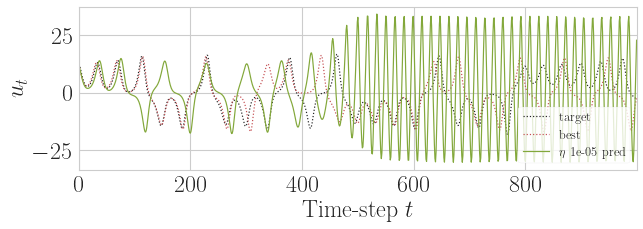

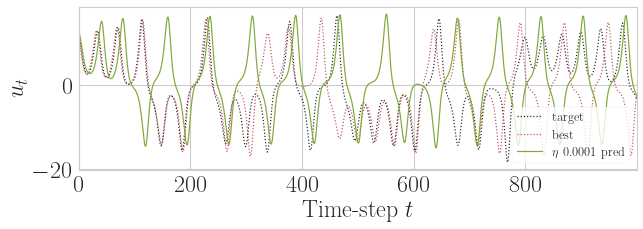

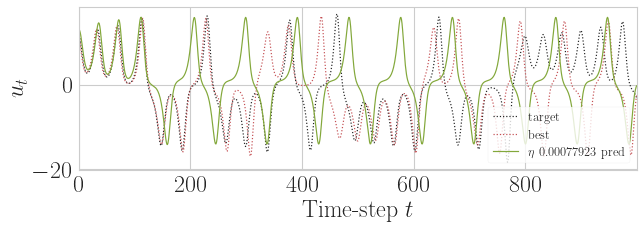

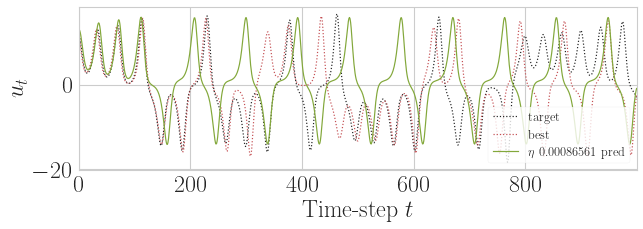

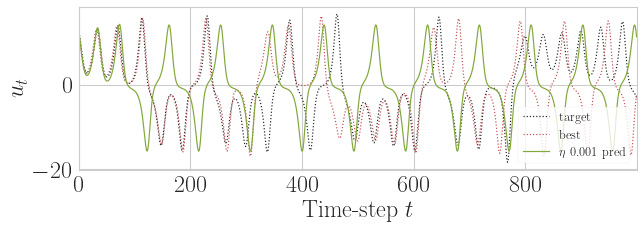

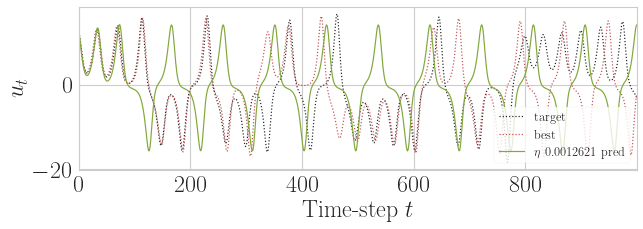

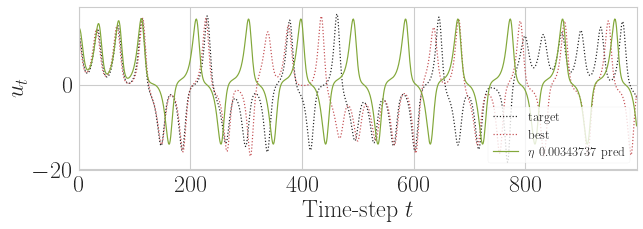

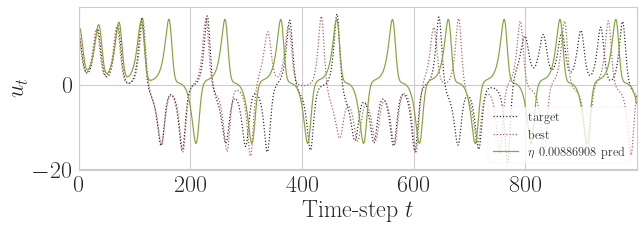

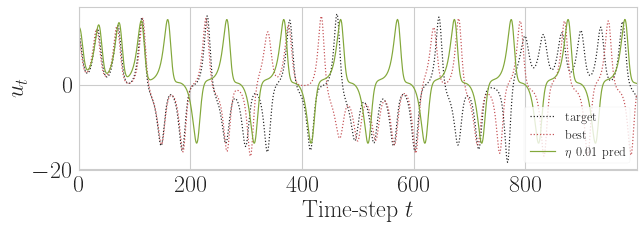

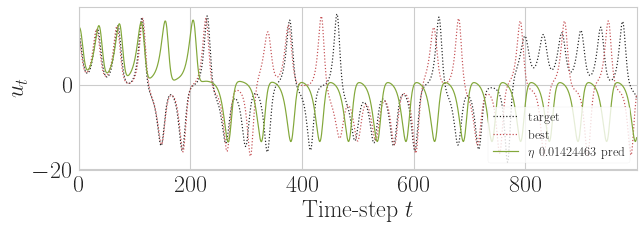

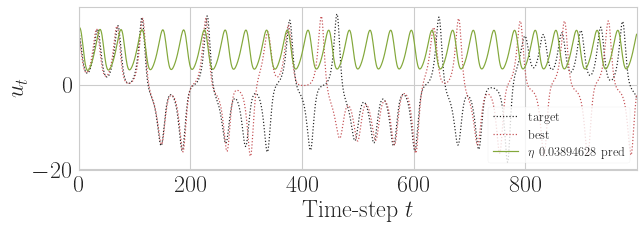

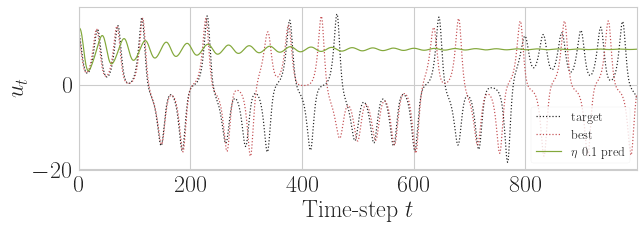

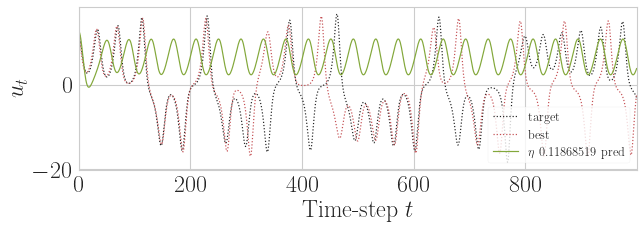

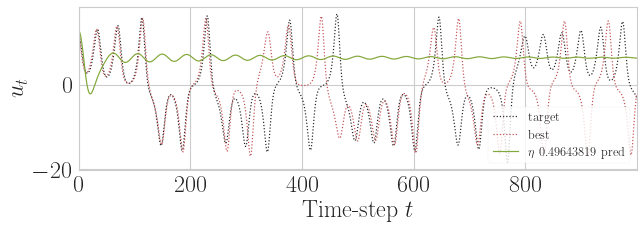

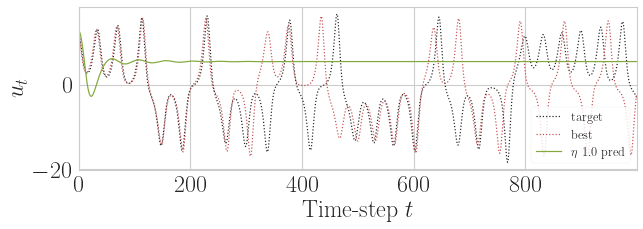

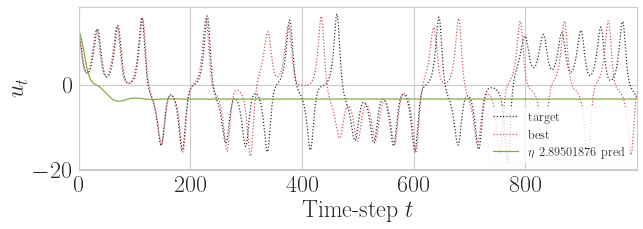

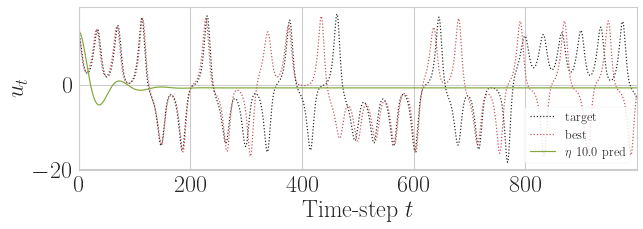

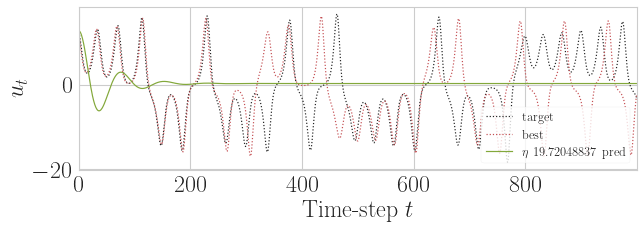

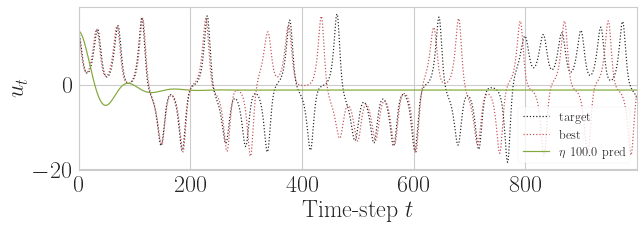

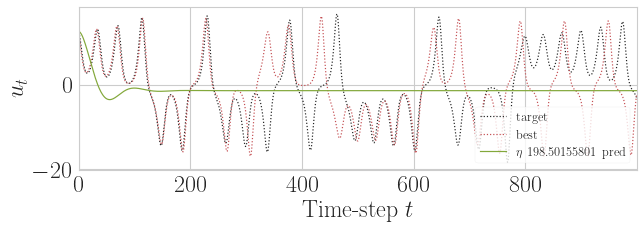

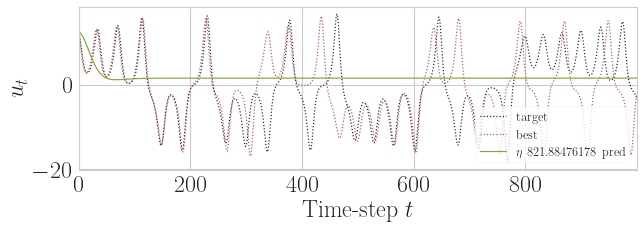

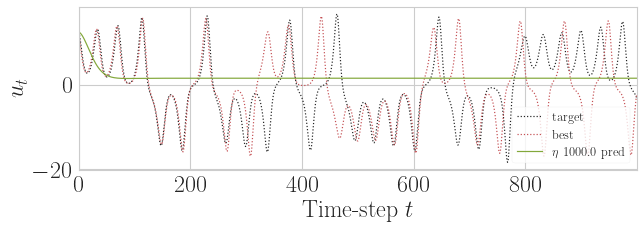

In [102]:
for i in range(len(all_preds)):
    plt.figure(figsize=(10,3))
    yHat = np.array(all_preds[i])
    plt.plot(signal[TRAINLENGTH:TRAINLENGTH+TEST],ls='dotted',
             c='k', label='target')
    plt.plot(preds28[TRAINLENGTH:TRAINLENGTH+TEST], ls='dotted',
             c='r', label='best')
    plt.plot(yHat[0,TRAINLENGTH:TRAINLENGTH+TEST],
             c='g', label=f'$\eta$ {np.round(all_eta[i],8)} pred')
    #plt.ylim(-20,20)
    plt.legend(loc='lower right')
    plt.xlabel('Time-step $t$')
    plt.ylabel('$u_t$')
    plt.legend(loc='lower right')
    plt.show()

In [55]:
all_preds[2][TRAINLENGTH:TRAINLENGTH+TEST]

array([], shape=(0, 16000), dtype=float32)

In [97]:
preds28 = np.array(dict_models['28']['Preds'])
nrmse28 = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+100],
                          preds28[TRAINLENGTH:TRAINLENGTH+100],
                          MM)

preds28.shape

(16000, 1)